In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.cluster.bicluster import SpectralBiclustering, SpectralCoclustering
from sklearn.feature_selection import VarianceThreshold
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

In [2]:
RAW_DATA_PATH = '../data/raw/'
small_set_path = RAW_DATA_PATH + 'TCGA-LUAD__GeneExpressionQuantification_TP_HTSeq-Counts.csv'

df = pd.read_csv(small_set_path)
old_columns = df.columns.values
old_columns[0] = "sample_id"
df.columns = old_columns
df = df.set_index('sample_id')
df.head()

,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,...,ENSG00000281881,ENSG00000281883,ENSG00000281887,ENSG00000281896,ENSG00000281903,ENSG00000281904,ENSG00000281909,ENSG00000281910,ENSG00000281912,ENSG00000281920
sample_id,,,,,,,,,,,,,,,,,,,,,
TCGA-44-8119-01A-11R-2241-07,11.776345,3.904838,10.817291,9.686358,8.812003,9.501046,12.756168,11.579184,10.048382,10.519689,...,4.700952,4.656452,3.904838,6.171237,5.074436,3.904838,4.173202,4.283819,5.838543,4.439279
TCGA-55-7994-01A-11R-2187-07,11.339486,5.187831,10.125137,9.811213,9.165108,10.690038,12.086822,11.454486,13.286788,12.223626,...,5.440617,4.333372,3.904838,7.074668,5.278835,3.904838,3.904838,3.904838,5.708560,5.015196
TCGA-NJ-A55R-01A-11R-A262-07,10.591315,4.330488,10.176231,10.075037,8.305751,8.352976,11.281279,11.603153,12.394335,10.545561,...,5.571902,4.595821,3.904838,6.012780,4.675587,3.904838,4.252797,3.904838,6.995198,5.289258
TCGA-55-A493-01A-11R-A24H-07,10.828277,5.432213,10.352388,9.133653,8.989667,10.804233,10.906860,12.019358,11.916397,11.151485,...,6.157904,3.904838,3.904838,7.316546,9.734122,4.270855,4.421094,4.535466,5.432213,4.631142
TCGA-64-1676-01A-01R-0946-07,13.215705,3.904838,12.168645,9.975047,9.040853,10.259979,10.632172,13.088130,11.241454,10.742986,...,4.374832,3.904838,3.904838,5.727581,5.196494,4.374832,3.904838,3.904838,6.665643,4.566635


In [3]:
# Feature Selection
def select_variance_features(df, threshold=20):
    columns = df.columns
    selector = VarianceThreshold(threshold=threshold)
    selector.fit_transform(df)
    labels = [columns[x] for x in selector.get_support(indices=True) if x]
    return pd.DataFrame(selector.fit_transform(df), columns=labels)

def scale_df(df):
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)
    return pd.DataFrame(df_scaled, columns=df.columns)

X = select_variance_features(df, threshold=15)
X = scale_df(X)
X.head()

,ENSG00000096088,ENSG00000129824,ENSG00000168484,ENSG00000171564
0,-0.325225,0.573035,-0.785012,1.561980
1,-0.799614,0.364644,-0.076057,-0.745340
2,1.386860,0.527084,-0.116086,0.911968
3,-1.222799,-1.065751,-1.438963,-0.212927
4,-0.264451,1.582115,0.150651,-0.615476


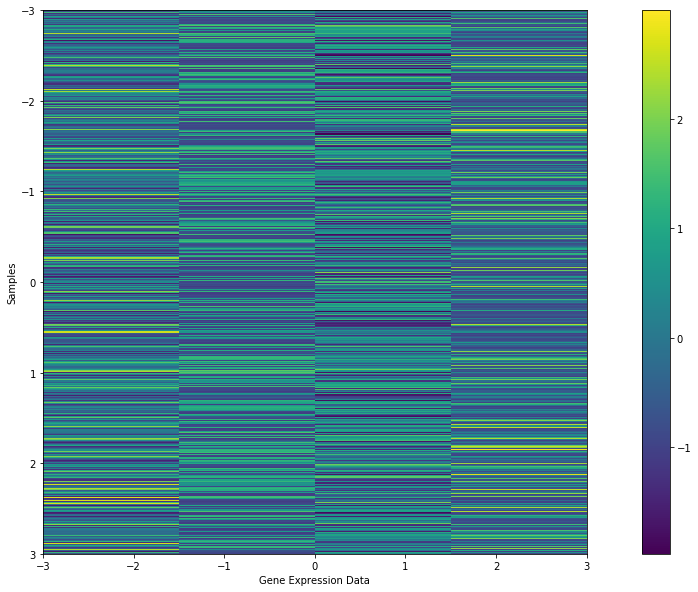

In [4]:
plt.figure(figsize=(20,10))
im = plt.imshow(X, extent=(-3, 3, 3, -3))
plt.ylabel("Samples")
plt.xlabel("Gene Expression Data")
plt.colorbar(im)
plt.show()

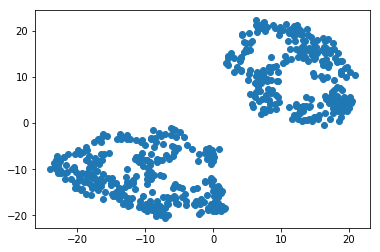

In [5]:
# Plot the scaled features using t-SNE
X_tsne = TSNE(n_components=2, perplexity=40).fit_transform(X)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
plt.show()

100%|██████████| 999/999 [00:12<00:00, 78.28it/s]


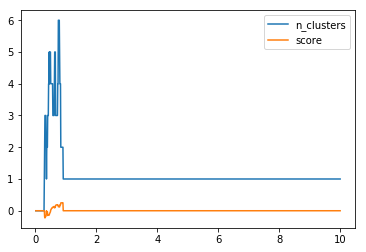

In [6]:
# Clustering
# Compute DBSCAN
epsilons = []
scores = []
n_clusters = []
PARAMETER_FACTOR = 100

# Find the best epsilon for clustering based on the silhouette coefficient

for eps in tqdm(range(1, 10 * PARAMETER_FACTOR, 1)):
    db = DBSCAN(eps=eps/PARAMETER_FACTOR, min_samples=10).fit(X)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

    # Evaluation
    epsilons.append(eps/PARAMETER_FACTOR)
    n_clusters.append(n_clusters_)
    score = 0
    if n_clusters_ > 1:
        score = metrics.silhouette_score(X, labels)
    scores.append(score)

plt.plot(epsilons, n_clusters, label="n_clusters")
plt.plot(epsilons, scores, label="score")
plt.legend()
plt.show()

In [7]:
max_index = scores.index(max(scores))
max_index/PARAMETER_FACTOR, scores[max_index], n_clusters[max_index]

(0.86, 0.25090663000873625, 2)

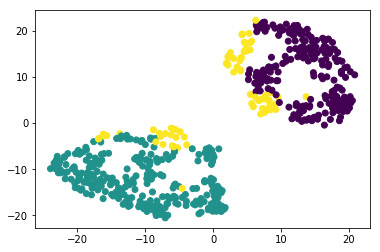

In [8]:
db = DBSCAN(eps=max_index/PARAMETER_FACTOR, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=[list(set(labels)).index(x) for x in labels])
plt.show()

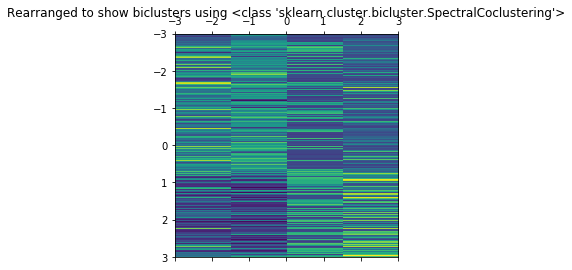

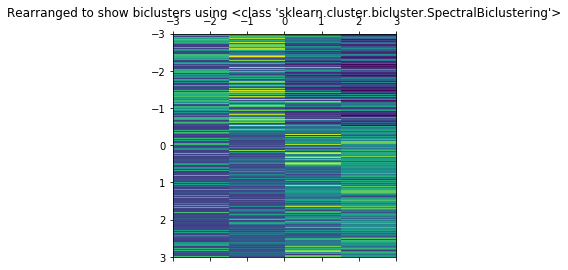

In [9]:
# Bi-Clustering using Spectral Co-Clustering and Spectral Bi-Clustering
models = [SpectralCoclustering(n_clusters=2), SpectralBiclustering(n_clusters=2)]
for model in models:
    model.fit(X)
    fit_data = X.values[np.argsort(model.row_labels_)]
    fit_data = fit_data[:, np.argsort(model.column_labels_)]
    plt.matshow(fit_data, extent=(-3, 3, 3, -3))
    plt.title("Rearranged to show biclusters using " + str(model.__class__))
    plt.show()